In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.utils.undirected import is_undirected
from torch_geometric.utils.isolated import contains_isolated_nodes

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

import networkx as nx

/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.visualization.display_graph import convert_torch_to_networkx_graph
import src.graph_analysis.shortest_paths as gsp


from src.processing.preprocessing import PreprocessingPipeline, MaskThreshold, KeepMonotonousNodeAttr, KeepNodeFeaturesSelector, NoValidationHandler, TurnUndirected, KeepKNearestNeighbors, LockKNearestGroupSendersToGroupReceivers, FillFeature, AddL2DistEdge, AddNLeapsFromClusterNode, KeepEdgeFeaturesSelector, RemoveIsolatedNodes

from src.models.model_pipeline import ModelPipeline

from src.models.nn.gnn_layers import MyGATConvNLeaps
from src.models.nn.ML_frameworks import GNNFramework
from src.models.kernel.gaussian_process import MyRBFGaussianProcessRegressor
from src.models.kernel.diffusion_kernel import MaternKernelModel

from src.utils import recursive_mkdirs

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Raw graphs

In [6]:
def get_fully_connected_edges(n_samples,x_embeddings):
    # fully connected
    edge_index_base = np.arange(n_samples)[np.newaxis,...]
    senders_index = np.repeat(edge_index_base,repeats=n_samples,axis=1)
    senders_index = torch.Tensor(senders_index)
    receivers_index = np.repeat(edge_index_base,repeats=n_samples,axis=0).reshape((1,n_samples**2))
    receivers_index = torch.Tensor(receivers_index)

    edge_index = torch.concat([senders_index,receivers_index],dim=0).to(torch.int64)
    # print("edge_index\n",edge_index)

    # remove self-loops
    is_self_loop = edge_index[0] == edge_index[1] 
    edge_index = edge_index[:,~is_self_loop]
    # print("edge_index\n",edge_index)

    # get edge_attr
    edge_attr_sim = 1-cdist(x_embeddings,x_embeddings,metric="cosine")
    edge_attr_sim = edge_attr_sim[edge_index[0,:],edge_index[1,:]]
    edge_attr_sim = torch.Tensor(edge_attr_sim).unsqueeze(dim=1)

    edge_attr_l2 = 1-cdist(x_embeddings,x_embeddings,metric="euclidean")
    edge_attr_l2 = edge_attr_l2[edge_index[0,:],edge_index[1,:]]
    edge_attr_l2 = torch.Tensor(edge_attr_l2).unsqueeze(dim=1)

    edge_attr = torch.concat([edge_attr_sim,edge_attr_l2],dim=1)
    edge_attr_names = ["similarity","l2"]

    return edge_index, edge_attr, edge_attr_names 

def generate_graph(n_samples,n_exp):
    x_embeddings = torch.rand((n_samples,2))*2 - 1

    x_exp = np.zeros(n_samples)
    x_exp[np.random.choice(np.arange(n_samples),size=n_exp,replace=False)] = 1
    x_exp = torch.Tensor(x_exp).unsqueeze(dim=1)

    x_liking = torch.randn(size=(n_samples,1))

    x = torch.concat([x_embeddings,x_exp,x_liking],axis=1)

    edge_index, edge_attr, edge_attr_names = get_fully_connected_edges(n_samples=n_samples,x_embeddings=x_embeddings)

    # get (train,val,complete_train,base) masks
    complete_train_mask = torch.ones(n_samples).to(bool)
    complete_train_mask[x_exp[:,0] > 0] = False
    base_mask = ~complete_train_mask

    graph = Data(
        x = x,
        x_names = ["embedding_0","embedding_1","experience","liking"],
        y = x_liking,
        y_names = ["values"],
        edge_index = edge_index,
        edge_attr = edge_attr,
        edge_attr_names = edge_attr_names,
        train_mask = complete_train_mask,
        val_mask = torch.zeros(n_samples).to(bool),
        base_mask = base_mask,
        complete_train_mask = complete_train_mask
    )
    return graph

Data(x=[10, 4], edge_index=[2, 90], edge_attr=[90, 2], y=[10, 1], x_names=[4], y_names=[1], edge_attr_names=[2], train_mask=[10], val_mask=[10], base_mask=[10], complete_train_mask=[10])
True False


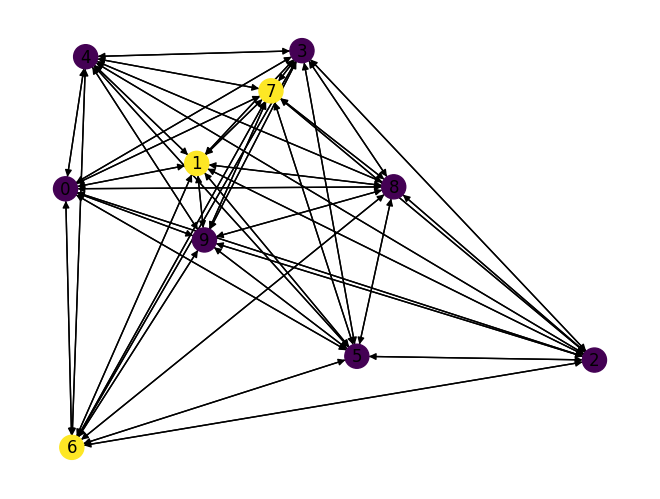

In [7]:
graph = generate_graph(10,3)
print(graph)
print(is_undirected(graph.edge_index,graph.edge_attr), contains_isolated_nodes(graph.edge_index,graph.num_nodes))

nx.draw(convert_torch_to_networkx_graph(graph), 
        pos = pd.DataFrame(graph.x,columns=graph.x_names)[["embedding_0","embedding_1"]].values,
        with_labels=True, 
        node_color= pd.DataFrame(graph.x,columns=graph.x_names)["experience"])

In [8]:
def preprocess_generated_graph(graph,kNN=3,kNNExp=3):
    preprocessing_pipeline = PreprocessingPipeline(
        complete_train_mask_selector=MaskThreshold("experience",threshold=0),
        transformators=[
            AddL2DistEdge(False,
                        x_embeddings_names=["embedding_0","embedding_1"]),
            KeepKNearestNeighbors(
                kNN,
                edge_attr_names_used=["similarity"],
                ord=0,
                mode="max"
            ),
            TurnUndirected(False),
            AddNLeapsFromClusterNode(
                verbose=False,
                cluster_mask_fn=lambda x: x["experience"] > 0,
                dist_edge_attr_name = ["L2_dist"]
            ),
            KeepEdgeFeaturesSelector(False,feature_names_kept=["similarity"]), # remove L2 dist that contains nan because of merge_graphs_edges
            KeepMonotonousNodeAttr(
                node_attr_name_used = "leaps_from_cluster",
                ascending = True,
                strict = True
            )
        ],
        validation_handler=NoValidationHandler(),
        base_mask_selector=MaskThreshold("experience",0.0,mode="strict_upper")
    )

    new_edge_index, new_edge_attr, new_x, new_y, new_edge_locked = preprocessing_pipeline.fit_transform(
        edge_index=graph.edge_index.numpy(),
        edge_attr=pd.DataFrame(graph.edge_attr,columns = graph.edge_attr_names),
        x=pd.DataFrame(graph.x, columns = graph.x_names),
        y=pd.DataFrame(graph.y, columns = graph.y_names),
        edge_locked=None
    )

    # ensure 1 leap has 3 connections to latent group

    locker_kNN_group = LockKNearestGroupSendersToGroupReceivers(
        group_senders_mask_fn=lambda x: x["experience"] > 0,
        group_receivers_mask_fn=lambda x: x["leaps_from_cluster"].isin([1.0, np.inf, -np.inf]),
        k = kNNExp,
        edge_attr_names_used = ["similarity"],
        ord = 0,
        mode="max"
    )

    edge_index,edge_attr,x,y,edge_locked = locker_kNN_group.fit_transform(
        edge_index = graph.edge_index.numpy(),
        edge_attr = pd.DataFrame(graph.edge_attr,columns = graph.edge_attr_names),
        x = new_x,
        y = new_y,
    )

    # add the locked edges
    # new_edge_index vs edge_index[edge_locked]
    new_edge_index,new_edge_attr = gsp.merge_graphs_edges(edge_index[:,edge_locked],
                                                        new_edge_index,
                                                        edge_attr.loc[edge_locked,["similarity"]],
                                                        new_edge_attr)

    preprocessing_pipeline = PreprocessingPipeline(
        complete_train_mask_selector=MaskThreshold("experience",threshold=0),
        transformators=[
            FillFeature(
                verbose=True,
                feature_name="liking",
                mask_fn=lambda x: x["experience"]<=0
            ),
            TurnUndirected(False),
            RemoveIsolatedNodes(False),
            AddL2DistEdge(False,
                        x_embeddings_names=["embedding_0","embedding_1"]),
            AddNLeapsFromClusterNode( # overwrites the previous feature leaps_from_cluster
                verbose=False,
                cluster_mask_fn=lambda x: x["experience"] > 0,
                dist_edge_attr_name = ["L2_dist"]
            ),
            KeepEdgeFeaturesSelector(False,feature_names_kept=["similarity"]), # remove L2 dist that contains nan because of merge_graphs_edges
        ],
        validation_handler=NoValidationHandler(),
        base_mask_selector=MaskThreshold("experience",0.0,mode="strict_upper")
    )

    edge_index, edge_attr, x, y, edge_locked = preprocessing_pipeline.fit_transform(
        edge_index=new_edge_index,
        edge_attr=new_edge_attr,
        x=x,
        y=y,
        edge_locked=edge_locked
    )

    graph = Data(
        x = torch.Tensor(x.values),
        x_names = x.columns.tolist(),
        y = torch.Tensor(y.values),
        y_names = y.columns.tolist(),
        edge_index = torch.Tensor(edge_index).to(torch.int64),
        edge_attr = torch.Tensor(edge_attr.values),
        edge_attr_names = edge_attr.columns.tolist(),
        train_mask = torch.Tensor(x["experience"] == 0).to(bool),
        val_mask = torch.zeros(len(x)).to(bool),
        base_mask = torch.Tensor(x["experience"] > 0).to(bool),
        complete_train_mask = torch.Tensor(x["experience"] == 0).to(bool),
    )

    return graph

PreprocessingPipeline fits AddL2DistEdge
PreprocessingPipeline fits KeepKNearestNeighbors2
Number of Edges before transform: 90
Number of Edges after transform: 20
PreprocessingPipeline fits TurnUndirected
PreprocessingPipeline fits AddNLeapsFromClusterNode
PreprocessingPipeline fits KeepEdgeFeaturesSelector
PreprocessingPipeline fits KeepMonotonousNodeAttr-StrictAscending
Number of Edges before transform: 28
Number of Edges after transform: 9
PreprocessingPipeline transforms data with AddL2DistEdge
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking']
PreprocessingPipeline transforms data with KeepKNearestNeighbors2
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking']
Number of Edges before transform: 90
Number of Edges after transform: 20
PreprocessingPipeline transforms data with TurnUndirected
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking']
PreprocessingPipeline transforms data with AddNLeapsFromClusterNode
x.col

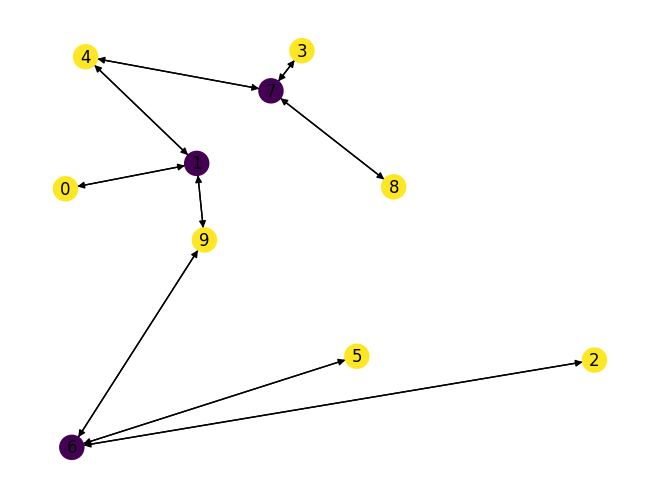

In [9]:
preprocessed_graph = preprocess_generated_graph(graph,2,1)

# small check 
print(is_undirected(graph.edge_index,graph.edge_attr), contains_isolated_nodes(graph.edge_index,graph.num_nodes))

nx.draw(convert_torch_to_networkx_graph(preprocessed_graph), 
        pos = pd.DataFrame(preprocessed_graph.x,columns=preprocessed_graph.x_names)[["embedding_0","embedding_1"]].values,
        with_labels=True, 
        node_color= pd.DataFrame(preprocessed_graph.x,columns=preprocessed_graph.x_names)["leaps_from_cluster"])

print(pd.DataFrame(preprocessed_graph.x,columns=preprocessed_graph.x_names)[["leaps_from_cluster"]])

mask_keep
 tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True])
new_graph.edge_index
 tensor([[0, 1, 1, 1, 2, 3, 4, 4, 5, 6, 6, 6, 7, 7, 7, 8, 9, 9],
        [1, 0, 4, 9, 6, 7, 1, 7, 6, 2, 5, 9, 3, 4, 8, 7, 1, 6]])
edge_index_to_remove
 tensor([False, False, False, False,  True, False, False, False, False,  True,
        False, False, False, False, False, False, False, False])
new_graph.edge_index
 tensor([[0, 1, 1, 1, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 8, 8],
        [1, 0, 3, 8, 6, 1, 6, 5, 4, 8, 2, 3, 7, 6, 1, 5]])
PreprocessingPipeline fits AddL2DistEdge
PreprocessingPipeline fits KeepKNearestNeighbors2
Number of Edges before transform: 72
Number of Edges after transform: 18
PreprocessingPipeline fits TurnUndirected
PreprocessingPipeline fits AddNLeapsFromClusterNode
PreprocessingPipeline fits KeepEdgeFeaturesSelector
PreprocessingPipeline fits KeepMonotonousNodeAttr-StrictAscending
Number of Edges before transform: 26
Number of Edges after transform: 8
Preproc

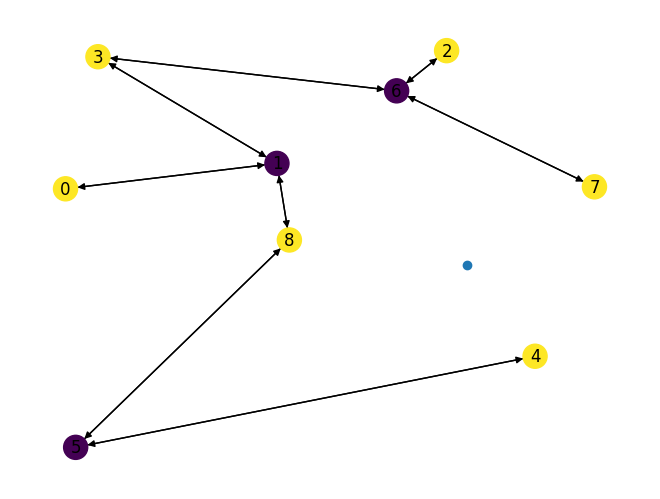

In [10]:
def remove_nodes(graph:Data, node_ids=torch.Tensor) -> Data:
    '''
    Careful: doesn't correct leaps_from_cluster

    '''
    new_graph = graph.clone()

    mask_keep = torch.ones(new_graph.num_nodes).to(bool)
    mask_keep[node_ids] = False
    print("mask_keep\n",mask_keep)

    new_graph.x = new_graph.x[mask_keep] 
    new_graph.y = new_graph.y[mask_keep]
    new_graph.train_mask = new_graph.train_mask[mask_keep]
    new_graph.val_mask = new_graph.val_mask[mask_keep]
    new_graph.base_mask = new_graph.base_mask[mask_keep] 
    new_graph.complete_train_mask = new_graph.complete_train_mask[mask_keep]
    
    edge_index_to_remove = torch.isin(new_graph.edge_index, node_ids).sum(dim=0).to(bool)
    print("new_graph.edge_index\n",new_graph.edge_index)
    print("edge_index_to_remove\n",edge_index_to_remove)
    new_graph.edge_index = new_graph.edge_index[:,~edge_index_to_remove]
    new_graph.edge_attr = new_graph.edge_attr[~edge_index_to_remove,:]

    sum_over_node_ids = new_graph.edge_index > np.inf
    for id in node_ids:
        sum_over_node_ids += new_graph.edge_index > id
    sum_over_node_ids = sum_over_node_ids.to(torch.int64)
    new_graph.edge_index -= sum_over_node_ids
    print("new_graph.edge_index\n",new_graph.edge_index)
    return new_graph

_graph = remove_nodes(preprocessed_graph,node_ids=torch.Tensor([2]).to(torch.int64))

_graph.edge_index, _graph.edge_attr, _graph.edge_attr_names = get_fully_connected_edges(_graph.num_nodes,x_embeddings=pd.DataFrame(_graph.x,columns=_graph.x_names)[["embedding_0","embedding_1"]].values)

_preprocessed_graph = preprocess_generated_graph(_graph,2,1)

nx.draw(convert_torch_to_networkx_graph(_preprocessed_graph), 
        pos = pd.DataFrame(_preprocessed_graph.x,columns=_preprocessed_graph.x_names)[["embedding_0","embedding_1"]].values,
        with_labels=True, 
        node_color= pd.DataFrame(_preprocessed_graph.x,columns=_preprocessed_graph.x_names)["leaps_from_cluster"])
plt.scatter([0],[0])
plt.show()

In [11]:
pd.DataFrame(_preprocessed_graph.x,columns=_preprocessed_graph.x_names)["leaps_from_cluster"]

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
5    0.0
6    0.0
7    1.0
8    1.0
Name: leaps_from_cluster, dtype: float32

In [12]:
def generate_data(n_samples):
    graph = generate_graph(n_samples=...,n_exp=...)
    preprocessed_graph = preprocess_generated_graph(graph)

    _graph = remove_nodes(graph=preprocessed_graph,node_ids=...)
    _graph.edge_index, _graph.edge_attr, _graph.edge_attr_names = get_fully_connected_edges(_graph.num_nodes,x_embeddings=pd.DataFrame(_graph.x,columns=_graph.x_names)[["embedding_0","embedding_1"]].values)
    _preprocessed_graph = preprocess_generated_graph(_graph,1,1)


{"n_samples":[20,30,40,50,30,40,50,60],"n_exp":[10,20,30,40,10,20,30,40]}

{'n_samples': [20, 30, 40, 50, 30, 40, 50, 60],
 'n_exp': [10, 20, 30, 40, 10, 20, 30, 40]}

In [ ]:
import itertools


def generate_whole_dataset(comb_pred_exp:list[tuple[int,int]],
                           levels_ratio_removed_exp:list[float],
                           dst_folder_path:str,
                           n_repeat:int=5,
                           kNN:int = 3,
                           kNNExp:int = 3):
    for repeat in range(n_repeat):
        for graph_id, (n_pred,n_exp) in enumerate(comb_pred_exp):
            recursive_mkdirs(os.path.join(dst_folder_path,f"graph_{repeat}_{graph_id}"))

            n_samples = n_pred+n_exp

            graph = generate_graph(n_samples=n_samples, n_exp=n_exp)
            preprocessed_graph = preprocess_generated_graph(graph,kNN=kNN,kNNExp=kNNExp)
            # save that graph
            torch.save(preprocessed_graph,os.path.join(dst_folder_path,f"graph_{repeat}_{graph_id}","original_graph"))
            for subgraph_id, ratio in enumerate(levels_ratio_removed_exp): 
                n_nodes_to_remove = int(ratio * n_exp)

                node_is_option = pd.DataFrame(preprocessed_graph.x,columns=preprocessed_graph.x_names)["experience"] >= 1
                node_ids_option = torch.where(torch.Tensor(node_is_option).to(bool))[0] 
                node_ids_to_remove = torch.Tensor(np.random.choice(node_ids_option,size=n_nodes_to_remove,replace=False)).to(torch.int64)
                
                _graph = remove_nodes(graph=preprocessed_graph,node_ids=node_ids_to_remove)
                _graph.edge_index, _graph.edge_attr, _graph.edge_attr_names = get_fully_connected_edges(_graph.num_nodes,x_embeddings=pd.DataFrame(_graph.x,columns=_graph.x_names)[["embedding_0","embedding_1"]].values)
                _preprocessed_graph = preprocess_generated_graph(_graph, kNN=kNN, kNNExp=kNNExp)
                # save that graph
                torch.save(_preprocessed_graph,os.path.join(dst_folder_path,f"graph_{repeat}_{graph_id}",f"subgraph_{subgraph_id}"))

# WARNING: Not to run again!
if False:
    factor_design_levels = {
        "n_pred": [10,20],
        "n_exp": [10,20,30,40]
    }
    comb_pred_exp = list(itertools.product(*factor_design_levels.values()))

    generate_whole_dataset(comb_pred_exp=comb_pred_exp,levels_ratio_removed_exp=[.1,.2,.5],dst_folder_path="data/generated/raw_graphs",n_repeat=5)


In [14]:
graph = torch.load("data/generated/raw_graphs/graph_3_5/subgraph_2",weights_only=False)

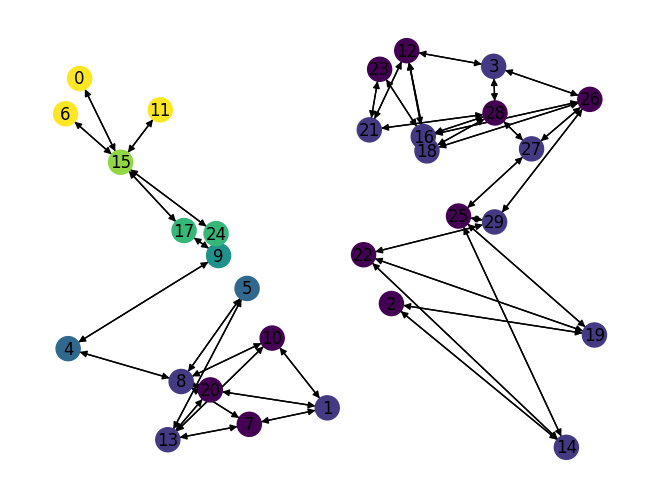

In [15]:
nx.draw(convert_torch_to_networkx_graph(graph), 
        pos = pd.DataFrame(graph.x,columns=graph.x_names)[["embedding_0","embedding_1"]].values,
        with_labels=True, 
        node_color= pd.DataFrame(graph.x,columns=graph.x_names)["leaps_from_cluster"])

In [16]:
max_leap = -1
for graph_folder in os.listdir("data/generated/raw_graphs"):
    for graph_name in os.listdir(os.path.join("data/generated/raw_graphs",graph_folder)):
        graph = torch.load(os.path.join("data/generated/raw_graphs",graph_folder,graph_name),weights_only=False)
        new_candidate = np.max(pd.DataFrame(graph.x,columns=graph.x_names)["leaps_from_cluster"])
        if new_candidate > max_leap:
            max_leap = new_candidate

print(max_leap)

6.0


In [17]:
graph.x_names

['embedding_0', 'embedding_1', 'experience', 'liking', 'leaps_from_cluster']

# Models' Predictions

In [ ]:
recursive_mkdirs("data/generated_1/predictions")

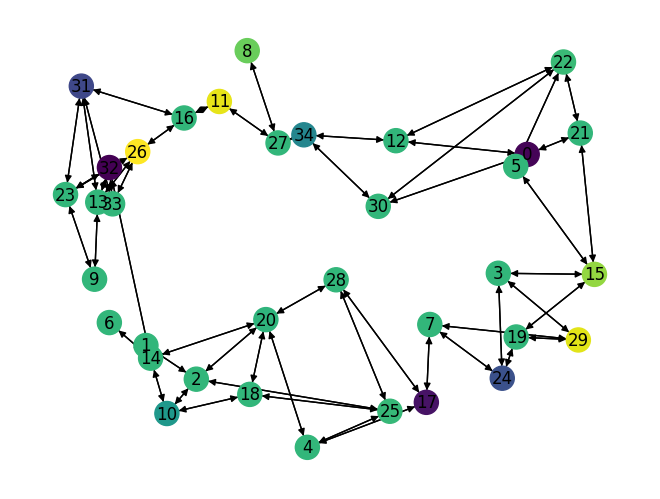

In [18]:
graph = torch.load("data/generated_1/raw_graphs/graph_1_6/subgraph_2",weights_only=False)

nx.draw(convert_torch_to_networkx_graph(graph), 
        pos = pd.DataFrame(graph.x,columns=graph.x_names)[["embedding_0","embedding_1"]].values,
        with_labels=True, 
        node_color= pd.DataFrame(graph.x,columns=graph.x_names)["liking"])

In [19]:
poss_params_GAT = np.random.randn(5,4)
poss_params_GAT

array([[ 1.68521178,  1.15500754, -0.38240173, -0.29058372],
       [ 0.38825385,  1.47228613, -0.36827066, -1.20336083],
       [ 0.11291888, -0.53686126,  0.21897347,  1.77355657],
       [ 1.1460462 , -0.90748395,  0.81427387,  1.0773187 ],
       [ 0.72747366, -1.04973983,  0.00632258, -0.58964017]])

params_version_id 0
data/generated_1/predictions/3NN_3ExpNN_GAT_amp-liking_edge/params_version_0
PreprocessingPipeline fits KeepMonotonousNodeAttr-StrictAscending
Number of Edges before transform: 50
Number of Edges after transform: 25
PreprocessingPipeline fits KeepFeaturesSelector
PreprocessingPipeline fits KeepEdgeFeaturesSelector
PreprocessingPipeline transforms data with KeepMonotonousNodeAttr-StrictAscending
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking', 'leaps_from_cluster']
Number of Edges before transform: 50
Number of Edges after transform: 25
PreprocessingPipeline transforms data with KeepFeaturesSelector
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking', 'leaps_from_cluster']
PreprocessingPipeline transforms data with KeepEdgeFeaturesSelector
x.columns.to_list() ['liking']
PreprocessingPipeline transform done
PreprocessingPipeline fits KeepMonotonousNodeAttr-StrictAscending
Number of Edges before transform: 60
Number of Ed

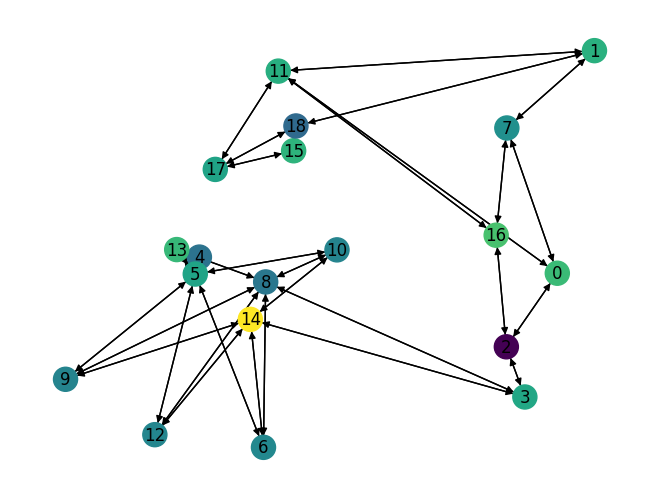

In [ ]:
dim_in = 1
use_bias, att_liking, amp_liking, edge, combine_att_amp = True, True, False, True, False

src_content_mask = torch.Tensor([True]*dim_in).to(torch.bool)
src_edge_mask = torch.Tensor([att_liking]*dim_in).to(torch.bool)
dst_content_mask = torch.Tensor([False]*dim_in).to(torch.bool)
dst_edge_mask = torch.Tensor([False]*dim_in).to(torch.bool)
my_module = MyGATConvNLeaps(
    n_leaps = 6, # I checked above there won't be more
    in_channels=(dim_in,dim_in),
    out_channels=1,
    heads=1,
    negative_slope=1.0,
    add_self_loops=False,
    edge_dim=1,
    dropout=0.0,
    bias=use_bias,
    src_content_mask=src_content_mask,
    src_edge_mask=src_edge_mask,
    dst_content_mask=dst_content_mask,
    dst_edge_mask=dst_edge_mask,
    src_content_weight_initializer="glorot" if amp_liking else "ones",
    edge_weight_initializer="glorot" if edge else "ones",
    src_content_require_grad=amp_liking,
    edge_require_grad=edge,
    src_content_edge_are_same=combine_att_amp)

model = GNNFramework(my_module,device)

validation_handler = NoValidationHandler()
preprocessing_pipeline = PreprocessingPipeline(
    transformators=[
        KeepMonotonousNodeAttr(
            node_attr_name_used = "leaps_from_cluster",
            ascending = True,
            strict = True
            ), # remove the undirectedness of the graph
        KeepNodeFeaturesSelector(True,
                                 feature_names_kept=["liking"]),
        KeepEdgeFeaturesSelector(False,
                                 feature_names_kept=["similarity"])
        ],
        complete_train_mask_selector=MaskThreshold(feature_name="experience",threshold=0),
        validation_handler=validation_handler,
        base_mask_selector=None
)

src_raw_graphs = "data/generated_1/raw_graphs"
dst_graphs = "data/generated_1/predictions/3NN_3ExpNN_GAT_bias_att-liking_edge"
for params_version_id, (bias_param, src_content_param, src_edge_param, edge_param) in enumerate(poss_params_GAT):
    print("params_version_id",params_version_id)
    print(os.path.join(dst_graphs,f"params_version_{params_version_id}"))
    
    next(iter(model.update_node_module.bias)).data.fill_(bias_param)
    # next(iter(model.update_node_module.lin_src_content.parameters())).data.fill_(src_content_param)
    next(iter(model.update_node_module.lin_src_edge.parameters())).data.fill_(src_edge_param)
    next(iter(model.update_node_module.lin_edge.parameters())).data.fill_(edge_param)

    # for parameter initialization, required for save_parameters
    model.predict(torch.Tensor([[0]*dim_in,[1]*dim_in,[2]*dim_in]),
                torch.Tensor([[0],
                              [1]]).to(torch.int64),
                torch.Tensor([[1]]),
                complete_train_mask = [False,True,False])
    

    recursive_mkdirs(os.path.join(dst_graphs,f"params_version_{params_version_id}"))
    model.save_parameters(os.path.join(dst_graphs,f"params_version_{params_version_id}","GAT_params"))

    for graph_folder_name in os.listdir(src_raw_graphs):
        for graph_name in os.listdir(os.path.join(src_raw_graphs,graph_folder_name)):
            graph = torch.load(os.path.join(src_raw_graphs,graph_folder_name,graph_name), weights_only=False)

            # preprocessing for GAT
            new_edge_index, new_edge_attr, new_x, new_y, new_edge_locked = preprocessing_pipeline.fit_transform(
                    edge_index=graph.edge_index.numpy(),
                    edge_attr=pd.DataFrame(graph.edge_attr,columns = graph.edge_attr_names),
                    x=pd.DataFrame(graph.x, columns = graph.x_names),
                    y=pd.DataFrame(graph.y, columns = graph.y_names),
                    edge_locked=None
            )

            GAT_graph = Data(
                    x = torch.Tensor(new_x.values),
                    x_names = new_x.columns.tolist(),
                    y = torch.Tensor(new_y.values),
                    y_names = new_y.columns.tolist(),
                    edge_index = torch.Tensor(new_edge_index).to(torch.int64),
                    edge_attr = torch.Tensor(new_edge_attr.values),
                    edge_attr_names = new_edge_attr.columns.tolist(),
                    train_mask = graph.train_mask,
                    val_mask = graph.val_mask,
                    base_mask = graph.base_mask,
                    complete_train_mask = graph.complete_train_mask,
            )

            y_pred = model.predict(node_attr = GAT_graph.x, 
                       edge_index= GAT_graph.edge_index,
                       edge_attr= GAT_graph.edge_attr,
                       complete_train_mask = GAT_graph.train_mask)
            y_pred = y_pred.detach()
            
            assert graph.y.size() == y_pred.size(), (graph.y.size(), y_pred.size())
            
            graph.y = y_pred 
            dst_folder = os.path.join(dst_graphs,f"params_version_{params_version_id}",graph_folder_name)
            recursive_mkdirs(dst_folder)
            torch.save(graph,os.path.join(dst_folder,graph_name))

nx.draw(convert_torch_to_networkx_graph(graph), 
        pos = pd.DataFrame(graph.x,columns=graph.x_names)[["embedding_0","embedding_1"]].values,
        with_labels=True, 
        node_color= y_pred)

In [8]:
graph = torch.load("data/generated/raw_graphs/graph_0_2/subgraph_2", weights_only=False)

validation_handler = NoValidationHandler()
preprocessing_pipeline = PreprocessingPipeline(
    transformators=[
        KeepMonotonousNodeAttr(
            node_attr_name_used = "leaps_from_cluster",
            ascending = True,
            strict = True
            ), # remove the undirectedness of the graph
        KeepNodeFeaturesSelector(True,
                                 feature_names_kept=["liking"]),
        KeepEdgeFeaturesSelector(False,
                                 feature_names_kept=["similarity"])
        ],
        complete_train_mask_selector=MaskThreshold(feature_name="experience",threshold=0),
        validation_handler=validation_handler,
        base_mask_selector=None
)

# preprocessing for GAT
new_edge_index, new_edge_attr, new_x, new_y, new_edge_locked = preprocessing_pipeline.fit_transform(
    edge_index=graph.edge_index.numpy(),
    edge_attr=pd.DataFrame(graph.edge_attr,columns = graph.edge_attr_names),
    x=pd.DataFrame(graph.x, columns = graph.x_names),
    y=pd.DataFrame(graph.y, columns = graph.y_names),
    edge_locked=None
)

GAT_graph = Data(
    x = torch.Tensor(new_x.values),
    x_names = new_x.columns.tolist(),
    y = torch.Tensor(new_y.values),
    y_names = new_y.columns.tolist(),
    edge_index = torch.Tensor(new_edge_index).to(torch.int64),
    edge_attr = torch.Tensor(new_edge_attr.values),
    edge_attr_names = new_edge_attr.columns.tolist(),
    train_mask = graph.train_mask,
    val_mask = graph.val_mask,
    base_mask = graph.base_mask,
    complete_train_mask = graph.complete_train_mask,
)



PreprocessingPipeline fits KeepMonotonousNodeAttr-StrictAscending
Number of Edges before transform: 60
Number of Edges after transform: 30
PreprocessingPipeline fits KeepFeaturesSelector
PreprocessingPipeline fits KeepEdgeFeaturesSelector
PreprocessingPipeline transforms data with KeepMonotonousNodeAttr-StrictAscending
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking', 'leaps_from_cluster']
Number of Edges before transform: 60
Number of Edges after transform: 30
PreprocessingPipeline transforms data with KeepFeaturesSelector
x.columns.to_list() ['embedding_0', 'embedding_1', 'experience', 'liking', 'leaps_from_cluster']
PreprocessingPipeline transforms data with KeepEdgeFeaturesSelector
x.columns.to_list() ['liking']
PreprocessingPipeline transform done


In [227]:
min_lengthscale, max_lengthscale = 1e-3, 1e2
poss_lengthscales_exp = np.random.exponential(scale=5,size=5)
poss_lengthscales = poss_lengthscales_exp[(poss_lengthscales_exp<= max_lengthscale) + (poss_lengthscales_exp >= min_lengthscale)]
poss_lengthscales

array([3.95352514, 4.52836734, 2.4484816 , 1.9592227 , 1.16869348])

In [ ]:
matern_model = MaternKernelModel(dim_out=1, nu = np.inf)


src_raw_graphs = "data/generated/raw_graphs"
dst_graphs = "data/generated/predictions/3NN_3ExpNN_DiffusionKernel"
for params_version_id, lengthscale in enumerate(poss_lengthscales):
    print("params_version_id",params_version_id)
    print(os.path.join(dst_graphs,f"params_version_{params_version_id}"))
    matern_model.lengthscale = lengthscale

    recursive_mkdirs(os.path.join(dst_graphs,f"params_version_{params_version_id}"))

    matern_model.save_parameters(os.path.join(dst_graphs,f"params_version_{params_version_id}","diffusion_kernel_params"))
    for graph_folder_name in os.listdir(src_raw_graphs):
        for graph_name in os.listdir(os.path.join(src_raw_graphs,graph_folder_name)):
            graph = torch.load(os.path.join(src_raw_graphs,graph_folder_name,graph_name), weights_only=False)


            y_pred = matern_model.predict(
                edge_index = graph.edge_index,
                edge_attr = torch.Tensor(pd.DataFrame(graph.edge_attr,columns=graph.edge_attr_names)["similarity"].values),
                x_pred_mask = torch.ones(graph.num_nodes).to(bool),
                x_base_mask = graph.base_mask,
                y_base = graph.y[graph.base_mask],
                num_nodes = graph.num_nodes
            )
            
            assert graph.y.size() == y_pred.size()
            
            graph.y = y_pred 
            dst_folder = os.path.join(dst_graphs,f"params_version_{params_version_id}",graph_folder_name)
            recursive_mkdirs(dst_folder)
            torch.save(graph,os.path.join(dst_folder,graph_name))

params_version_id 0
data/predictions/3NN_3ExpNN_DiffusionKernel/params_version_0
params_version_id 1
data/predictions/3NN_3ExpNN_DiffusionKernel/params_version_1
params_version_id 2
data/predictions/3NN_3ExpNN_DiffusionKernel/params_version_2
params_version_id 3
data/predictions/3NN_3ExpNN_DiffusionKernel/params_version_3
params_version_id 4
data/predictions/3NN_3ExpNN_DiffusionKernel/params_version_4


In [13]:
min_lengthscale, max_lengthscale = 1e-3, 1e2
poss_lengthscales_exp = np.random.exponential(scale=5,size=5)
poss_lengthscales = poss_lengthscales_exp[(poss_lengthscales_exp<= max_lengthscale) + (poss_lengthscales_exp >= min_lengthscale)]
poss_lengthscales

array([13.49531285,  1.83145465,  0.49122012,  0.09173949,  1.54050089])

In [14]:
gpr = MyRBFGaussianProcessRegressor(
            dim_out=1,
            lengthscale=1, # will be fitted
            length_scale_bounds="fixed",
            dist_metric="cosine"
    )

y_pred = gpr.predict(
    node_attr = torch.Tensor(pd.DataFrame(graph.x,columns=graph.x_names)[["embedding_0","embedding_1"]].values),
    x_pred_mask = torch.ones(graph.num_nodes).to(bool),
    x_base_mask = graph.base_mask,
    y_base = graph.y[graph.base_mask]
)

src_raw_graphs = "data/generated/raw_graphs"
dst_graphs = "data/generated/predictions/3NN_3ExpNN_GaussianProcess"
for params_version_id, lengthscale in enumerate(poss_lengthscales):
    print("params_version_id",params_version_id)
    print(os.path.join(dst_graphs,f"params_version_{params_version_id}"))

    gpr.lengthscale = lengthscale
    recursive_mkdirs(os.path.join(dst_graphs,f"params_version_{params_version_id}"))
    gpr.save_parameters(os.path.join(dst_graphs,f"params_version_{params_version_id}","gaussian_process_params"))

    for graph_folder_name in os.listdir(src_raw_graphs):
        for graph_name in os.listdir(os.path.join(src_raw_graphs,graph_folder_name)):
            graph = torch.load(os.path.join(src_raw_graphs,graph_folder_name,graph_name), weights_only=False)


            y_pred = gpr.predict(
                node_attr = torch.Tensor(pd.DataFrame(graph.x,columns=graph.x_names)[["embedding_0","embedding_1"]].values),
                x_pred_mask = torch.ones(graph.num_nodes).to(bool),
                x_base_mask = graph.base_mask,
                y_base = graph.y[graph.base_mask]
            )
            
            assert graph.y.size() == y_pred.size()
            
            graph.y = y_pred 
            dst_folder = os.path.join(dst_graphs,f"params_version_{params_version_id}",graph_folder_name)
            recursive_mkdirs(dst_folder)
            torch.save(graph,os.path.join(dst_folder,graph_name))

params_version_id 0
data/generated/predictions/3NN_3ExpNN_GaussianProcess/params_version_0
params_version_id 1
data/generated/predictions/3NN_3ExpNN_GaussianProcess/params_version_1
params_version_id 2
data/generated/predictions/3NN_3ExpNN_GaussianProcess/params_version_2
params_version_id 3
data/generated/predictions/3NN_3ExpNN_GaussianProcess/params_version_3
params_version_id 4
data/generated/predictions/3NN_3ExpNN_GaussianProcess/params_version_4
